In [19]:
using DrWatson
@quickactivate "projectdir()"

In [114]:
using Ripserer, PersistenceDiagrams, Plots, ProgressMeter, Random
include(scriptsdir("networks.jl"))

read_network (generic function with 1 method)

In [106]:
function generate_sbm(n, k, p, r)
    f = (x, y) -> r + p * (x == y)
    Z = rand(1:k, n)
    return generate_rdpg(f, Z)
end

function diagram(X, dim_max; alpha=true)
    points = tuple.(eachcol(X)...)
    dgm = ripserer(Alpha(points), dim_max=dim_max)
    return dgm
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X, dim_max)
    DY = diagram(Y, dim_max)
    # return [Bottleneck()(DX[d], DY[d]) for d in 1:dim_max+1]
    return [Bottleneck()(DX[1], DY[1])]
end

bottleneck_distances (generic function with 1 method)

In [115]:
function scale_embeddings(X)
    return (X .- mean(eachrow(X))') * (X'X)^(-0.5)
end

function simulate_one(A, d, epsilon, method)
    X, _, _ = spectral_embeddings(A, d=d + 1, scale=false)
    A_private = edgeFlip(A, ϵ=epsilon)

    if method == :eps
        A_private = A_private .- privacy(ϵ=epsilon)
    end

    X_private, _, _ = spectral_embeddings(A_private, d=d + 1, scale=false)

    if method == :eps
        X_private = X_private ./ (1 - 2 * privacy(ϵ=epsilon))
    elseif method == :noeps
        X = scale_embeddings(X)
        X_private = scale_embeddings(X_private)
    end
    return bottleneck_distances(X, X_private, d)
end

simulate_one (generic function with 1 method)

In [116]:
function V(V, fun=mean; slice=1, i=1)
    if slice == 1
        reshape(fun(V, dims=1), size(V, 3), size(V, 2), :)[i, :]
    elseif slice == 2
        reshape(fun(V, dims=1), size(V, 3), size(V, 2), :)[:, i]
    end
end

V (generic function with 2 methods)

## A smaller simulation

In [137]:
repeats = 5
Ks = [1/2, 2/3, 1]
N = [50, 100, 200, 500, 750, 1000, 1500];

In [138]:
p, r = 0.4, 0.1, 0.15
clust = 3
n = length(N);

In [139]:
results = [zeros(repeats, n) for _ in 1:length(Ks)];

In [140]:
Random.seed!(2022)
prog = Progress(convert(Int, n * repeats * length(Ks)))
for i in 1:n
    A = generate_sbm(N[i], clust, p, r)
    for j in 1:repeats
        for k in 1:length(Ks)
        
            ϵn = log(N[i])^(Ks[k])
            error = simulate_one(A, 2, ϵn, :eps)
            results[k][j, i] = error[1]
            next!(prog)

        end
    end
end

Progress:   6%|██▍                                      |  ETA: 0:00:02

Progress:  14%|█████▉                                   |  ETA: 0:00:01

Progress:  21%|████████▋                                |  ETA: 0:00:02

Progress:  25%|██████████▏                              |  ETA: 0:00:02

Progress:  28%|███████████▍                             |  ETA: 0:00:02

Progress:  30%|████████████▌                            |  ETA: 0:00:02

Progress:  32%|█████████████▎                           |  ETA: 0:00:02

Progress:  34%|██████████████                           |  ETA: 0:00:03

Progress:  36%|██████████████▉                          |  ETA: 0:00:03

Progress:  38%|███████████████▋                         |  ETA: 0:00:03

Progress:  40%|████████████████▍                        |  ETA: 0:00:03

Progress:  42%|█████████████████▏                       |  ETA: 0:00:03

Progress:  44%|██████████████████                       |  ETA: 0:00:03

Progress:  45%|██████████████████▍                      |  ETA: 0:00:04

Progress:  46%|██████████████████▊                      |  ETA: 0:00:04

Progress:  47%|███████████████████▏                     |  ETA: 0:00:04

Progress:  48%|███████████████████▌                     |  ETA: 0:00:05

Progress:  49%|███████████████████▉                     |  ETA: 0:00:05

Progress:  50%|████████████████████▎                    |  ETA: 0:00:05

Progress:  50%|████████████████████▊                    |  ETA: 0:00:05

Progress:  51%|█████████████████████▏                   |  ETA: 0:00:05

Progress:  52%|█████████████████████▌                   |  ETA: 0:00:06

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:06

Progress:  54%|██████████████████████▎                  |  ETA: 0:00:06

Progress:  55%|██████████████████████▋                  |  ETA: 0:00:06

Progress:  56%|███████████████████████                  |  ETA: 0:00:06

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:06

Progress:  58%|███████████████████████▉                 |  ETA: 0:00:07

Progress:  59%|████████████████████████▎                |  ETA: 0:00:07

Progress:  60%|████████████████████████▋                |  ETA: 0:00:07

Progress:  61%|█████████████████████████                |  ETA: 0:00:08

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:08

Progress:  63%|█████████████████████████▊               |  ETA: 0:00:08

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:08

Progress:  65%|██████████████████████████▌              |  ETA: 0:00:08

Progress:  66%|███████████████████████████              |  ETA: 0:00:08

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:09

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:09

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:09

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:09

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:09

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:08

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:09

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:09

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:09

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:09

Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:09

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:09

Progress:  78%|████████████████████████████████         |  ETA: 0:00:09

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:09

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:09

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:09

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:09

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:09

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:08

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:08

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:08

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:08

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:08

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:08

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:07

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:07

Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:06

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:06

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:05

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:05

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:04

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:03

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


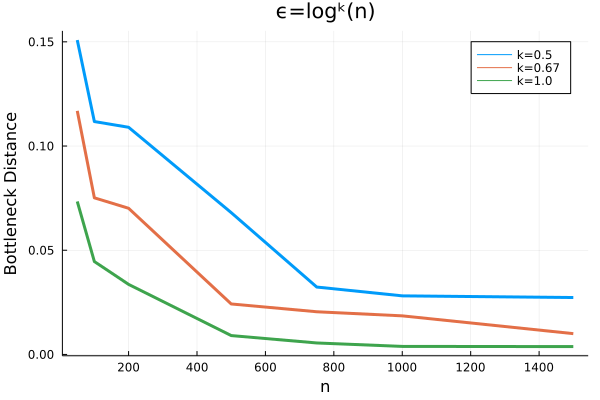

In [155]:
plt = plot(title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")
for k in 1:length(Ks)
    plot!(plt, N,
        mean(results[k], dims=1)',
        # ribbon=std(results[k], dims=1),
        ms=:o,
        label = "k=$(round(Ks[k], digits=2))",
        lw=3, fillapha=0.01,
    )
end
plt